## Лабораторная работа по курсу "Искусственный интеллект"
## Многослойный персептрон

| Студент |  Ефимов  |
|---------|----------|
| Группа  | М8О-307Б |

Используемый датасет представляет собой множество написанных вручную цифр, от 0 до 9 включительно, и доступен [по ссылке](https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Data/MNIST/mnist.pkl.gz).

In [1]:
data_folder = "data/mnist/"
# !curl -o {data_folder + "mnist.pkl.gz"} https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Data/MNIST/mnist.pkl.gz
# !gzip -d {data_folder + "mnist.pkl.gz"}

Перед загрузкой данных следует заранее добавить все используемые библиотеки:

In [2]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.metrics         import confusion_matrix, ConfusionMatrixDisplay   

# Custom libraries
from deeplearn.layers   import Layer, Softmax, CrossEntropyLoss
from deeplearn.nnetwork import NeuralNetwork

Собственно сама загрузка данных:

In [3]:
import pickle
with open(data_folder + 'mnist.pkl','rb') as f:
    MNIST = pickle.load(f)

В переменной `MNIST` под ключем `Train` содержатся данные, разделенные на особенности и метки соответственно, но в ней нет данных для тестирования. Их можно сразу разделить: 

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    np.array(MNIST['Train']['Features'].astype(np.float32) / 255),
    np.array(MNIST['Train']['Labels']),
    test_size=0.3)

X_train.shape

(29400, 784)

Особенности нормализуются сразу (делением на $255$).

Создание и конфигурация нейронной сети:

In [5]:
nnet = NeuralNetwork()
nnet.configure(epoch=10, learning_rate=0.03, batch_size=5)
nnet.add_layer(Layer(784, 10))
nnet.add_layer(Softmax())

In [6]:
%time nnet.train(X_train, y_train)

CPU times: user 6.38 s, sys: 16.4 ms, total: 6.4 s
Wall time: 6.41 s


In [7]:
y_predict = nnet.predict(X_test)
y_predict

array([[9.93793852e-01, 6.92238672e-12, 1.03264484e-03, ...,
        1.02942196e-08, 8.99979292e-05, 5.84514461e-07],
       [1.97294949e-08, 1.96927376e-07, 2.25584457e-07, ...,
        2.02678165e-02, 1.05943872e-03, 9.77857953e-01],
       [7.65107805e-07, 3.86853353e-07, 7.59261593e-06, ...,
        1.26822029e-02, 8.94650320e-05, 3.69709143e-03],
       ...,
       [1.69657009e-04, 1.42136688e-06, 8.70756995e-04, ...,
        9.18023417e-07, 2.09250744e-01, 5.58582147e-04],
       [9.99027284e-01, 2.17257126e-07, 3.64293750e-04, ...,
        4.37854769e-04, 8.08488529e-07, 1.97393544e-07],
       [2.40707582e-06, 9.45823445e-10, 9.98497324e-01, ...,
        1.60760147e-08, 1.30811182e-05, 4.49978023e-05]])

Нейронная сеть возвращает матрицу вероятностей, каждая строка, в которой содержатся вероятности для каждого числа, соответствует входному образцу на этой же строке. Построчная сумма вероятностей равна единице (из определения _Softmax_):

In [8]:
y_predict[0].sum()

0.9999999999999998

Для получения числа из каждой строки, нужно взять индекс максимума для каждой строки (индексы соответствуют меткам):

In [9]:
y_predict = np.argmax(y_predict, axis=1)

In [10]:
(y_predict == y_test).mean()

0.9173809523809524

При всех повторных запусках точность была больше $90\%$, но не исключено, что она может быть низкой из-за неудачного начального распределения весов при обучении.

Матрица ошибок имеет вид:

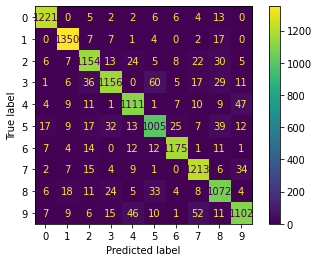

In [11]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_predict)).plot()

Интересно заметить, что большая часть ошибок появляется при определении числа 5.

Текущая конфигурация системы работает достаточно хорошо, но не достаточно быстро (~6 секунд за одну тренировку), что не есть хорошо. Скорость можно улучшить следующими способами:

* Уменьшить количество эпох;
* Увеличить коэффициент скорости тренировки;
* Увеличить количество обрабатываемых данных за один проход (размер батчей).

Начинать лучше с последнего метода, так как первый метод имеет большой шанс уменьшения точности, а второй - риск, что тренировка будет перескакивать минимум. Третий метод является наилучшим (хотя бы в данном случае), так как для таких больших данных явно теряется скорость из-за обработки только пяти образцов за раз. Пусть сеть будет обрабатывать за раз 20 образцов (остальные настройки те же):

In [12]:
nnet = NeuralNetwork()
nnet.configure(epoch=10, learning_rate=0.03, batch_size=20)
nnet.add_layer(Layer(784, 10))
nnet.add_layer(Softmax())

In [13]:
%time nnet.train(X_train, y_train)

CPU times: user 2.35 s, sys: 7.07 ms, total: 2.36 s
Wall time: 2.37 s


In [14]:
y_predict = np.argmax(nnet.predict(X_test), axis=1)
(y_predict == y_test).mean()

0.9176190476190477

Точность сравнительно не изменилась, но скорость явно увеличилась в три раза.

Для графической демонстрации, тренировка нейронной сети будет выполняться одну эпоху, после чего высчитывается текущая точность. Это повторится 10 раз, что эквивалентно тренировки в промежутке 10 эпох:

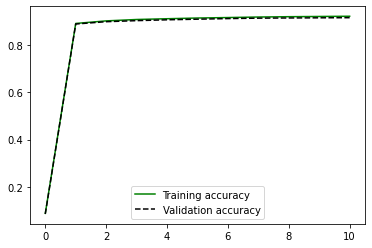

In [15]:
def get_loss_acc(net, x, y, loss=CrossEntropyLoss()):
    y_pred = net._forward_calc(x)
    l = loss.calc_forward(y_pred, y)
    pred = np.argmax(y_pred, axis=1)
    acc = (pred == y).mean()
    return l, acc

def train_plot(net, count=30):
    train_accuracies = []
    test_accuracies  = []
    
    for i in range(count + 1):
        _, train_a = get_loss_acc(nnet, X_train, y_train)
        _, test_a  = get_loss_acc(nnet, X_test, y_test)
        
        train_accuracies.append(train_a)
        test_accuracies.append(test_a)
        
        nnet.train(X_train, y_train)

    plt.plot(range(count + 1), train_accuracies, 'g-')
    plt.plot(range(count + 1), test_accuracies,  'k--')
    plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower center')
    plt.show()
    
nnet = NeuralNetwork()
nnet.configure(epoch=1, learning_rate=0.03, batch_size=20)
nnet.add_layer(Layer(784, 10))
nnet.add_layer(Softmax())
train_plot(nnet, 10)

Из графика можно сделать два вывода:
* Уже после первой эпохи точность близка к предельно возможной для данной конфигурации
* Разность между точностями на обучающих и тренировочных образцах минимальна, что означает отсутствие переобучения

Стоит еще дополнительно заметить, что процент точности можно увеличить, если увеличить количество промежуточных нейронов (но для этого нужно добавить дополнительный слой):

In [16]:
nnet = NeuralNetwork()
nnet.configure(epoch=10, learning_rate=0.03, batch_size=20)
nnet.add_layer(Layer(784, 128, activator_type='tanh'))
nnet.add_layer(Layer(128, 10))
nnet.add_layer(Softmax())

%time nnet.train(X_train, y_train)

y_predict = np.argmax(nnet.predict(X_test), axis=1)
(y_predict == y_test).mean()

CPU times: user 52.4 s, sys: 54 s, total: 1min 46s
Wall time: 13.8 s


0.9542063492063492

Но для этих 4-5 процент уходит много ресурсов, поэтому так следует поступать только при необходимости.

В качестве примера можно еще рассмотреть датасет `Fashion MINST`, 
в котором содержутся монотонные $28х28$ картинки одежды и соответствующие ей категории:

In [26]:
data_folder = "data/fashion-mnist"
train = pd.read_csv(data_folder + "/fashion-mnist_train.csv").values
test = pd.read_csv(data_folder + "/fashion-mnist_test.csv").values

y_train, X_train = train[:, 0], train[:, 1:]
y_test, X_test = test[:, 0], test[:, 1:]
print(y_train)
print(X_train.shape)

[2 9 6 ... 8 8 7]
(60000, 784)


Данные могут принимать значения в промежутке $[0, 255]$ и, если их не нормализовать, можно не только потерять точность, но и получить переполнение.

In [27]:
X_train = X_train / 255
X_test = X_test / 255
np.max(X_train)

1.0

Так как количество входных параметров совпадает, можно воспользоваться нейронной сетью с той же конфигурацией.

In [28]:
nnet = NeuralNetwork()
nnet.configure(epoch=10, learning_rate=0.03, batch_size=20)
nnet.add_layer(Layer(784, 10))
nnet.add_layer(Softmax())

%time nnet.train(X_train, y_train)

y_predict = np.argmax(nnet.predict(X_test), axis=1)
(y_predict == y_test).mean()

CPU times: user 5.57 s, sys: 388 µs, total: 5.57 s
Wall time: 5.58 s


0.855

Для однослойной нейронной сети точность в $85%$ средняя, и для ее повышения можно 
воспользоваться сверточными слоями (т.е. сверточ